# Intro
In this report, we look at left hemisphere MANIA 1.0 results for seven HCP subjects with MMP1.0 parcellation at group mode. We also look at the confidence of edges.

### Operating Point
Let's first look at **(density, threshold, NAR)** operating points. On the scatter plot, you can hover to see the NAR information. NARs are scaled by 100 for visualization purposes.

In [72]:
from py2neo import Node, Relationship, Graph
from numpy.random import rand
import numpy as num
from bokeh.plotting import output_notebook,figure,ColumnDataSource, show
from bokeh.layouts import row,column,gridplot
from bokeh.models import HoverTool
from utils import *
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [73]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [74]:
# NEO4J database call for results
graph = Graph()
c1 = '''MATCH (:MANIA)-[r:SUB]-(n:RES)
 return r.id as sub, n.threshold as t,n.density as d,n.NAR as nar'''
A = graph.run(c1)
# Plotting the data
s = []
hover = HoverTool(tooltips=[
    ("NAR", "$NAR"),
    ("SUBJECT", "$SUB"),
])
sub = []
t = []
d = []
nar = []
for i,w in enumerate(A):
    sub = sub + [w['sub']]
    nar = nar + [w['nar']*100]
    d = d + [w['d']*100]
    t = t + [w['t']]
source = ColumnDataSource(data=dict(
    sub=sub,
    t=t,
    d=d,
    nar=nar
))
hover = HoverTool(tooltips=[
    ("NAR", "@nar"),
    ("SUBJECT", "@sub"),
])
p = figure(plot_width=500, plot_height=500, tools=[hover],title="MANIA 1.0 Operating points",y_axis_label = "density",x_axis_label = "threshold")
p.circle('t', 'd', size=20, source=source)
show(p)

### JACCARD SIMILARITY
Next we look at the jaccard similarity between each pair of subject networks

In [8]:
c1 = '''MATCH (n:ROI)-[r:MANIA{connected:1}]->(m:ROI)
 return n.name as N1,m.name as N2,r.SUB as sub'''
A = graph.run(c1)
net = {}
E = {}
for w in A:
    try:
        E[w['N1']+w['N2']] += 1
    except KeyError:
        E[w['N1']+w['N2']] = 1
    i = int(w['N1'][1:])-1
    j = int(w['N2'][1:])-1
    try:
        net[w['sub']][i,j] = 1
    except KeyError:
        net[w['sub']]=num.zeros((180,180))
from itertools import combinations
S = sorted(net.keys())
A =  num.zeros((7,7))
Z = []
for w,v in combinations(S,2):
    tmp = sim(net[w],net[v])
    A[S.index(w),S.index(v)] = tmp
    Z = Z + [tmp]
from collections import Counter
c = Counter(list(E.values()))
per = []
K=[]
for v in c:
    per = per + [int(c[v]*100/len(E))]
    K = K + [v]
cc = sorted(zip(K,per),reverse=True)
per = [xx[1] for xx in cc]
K = [xx[0] for xx in cc]

Text(0.5,1,'Jaccard Index distribution among 7*6 subject pairs')

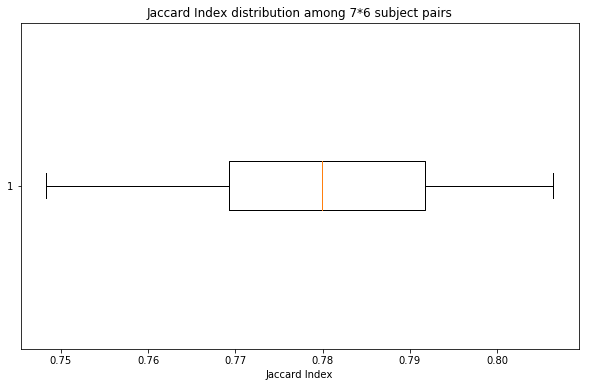

In [83]:
plt.figure(figsize=(10, 6))
plt.boxplot(Z,0, 'rs', 0)
plt.xlabel('Jaccard Index')
plt.title('Jaccard Index distribution among 7*6 subject pairs')

### Edge type
Next we look at the edge types across all 7 networks. Edge type 7 means the edge is present in all 7 networks, 6 means the edge is present only in 6 subjects and so on. We only considers Edges that are present in at least on subject here. Below you can see the percentage of each edge type.

In [86]:
p = figure(plot_width=500, plot_height=500,title="Edge type",y_axis_label = "Frequecy",x_axis_label = "Type")
source = ColumnDataSource(data=dict(
    per=per,
    ind = K
))
p.vbar(x=K, top=per,width=.75)
show(p)